<a href="https://colab.research.google.com/github/darshi0301/Rice-Forecasting/blob/main/Rice_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RICE FORECASTING FOR 2028**

In [32]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

file_path = '/content/drive/My Drive/Colab Notebooks/rice_all.csv'
df = pd.read_csv(file_path)

# Display the first few rows

df.head()
df.columns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Index(['Season', 'Sown (000 Acres)', 'Harvested (000 Acres)',
       'Average Yield (Bushels/Acre)', 'Production (000 Bushels)'],
      dtype='object')

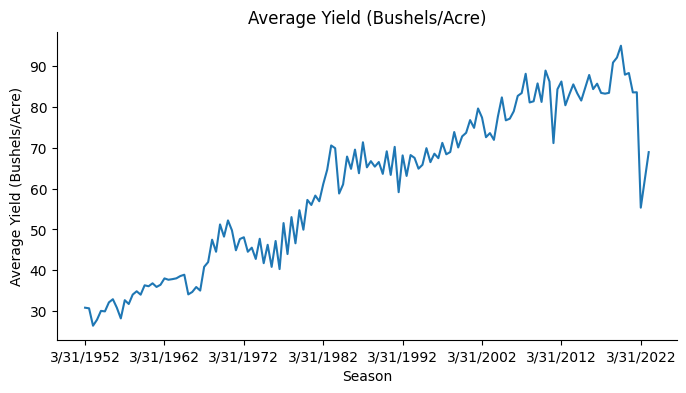

In [33]:
# @title Average Yield (Bushels/Acre)

from matplotlib import pyplot as plt

# Set 'Season' as the index if not already done
df.set_index('Season', inplace=True)

# Plot the line chart
df['Average Yield (Bushels/Acre)'].plot(
    kind='line',
    figsize=(8, 4),
    title='Average Yield (Bushels/Acre)'
)

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Add labels for clarity
plt.xlabel('Season')  # X-axis label
plt.ylabel('Average Yield (Bushels/Acre)')  # Y-axis label

# Show the plot
plt.show()






In [54]:
last_date = df.index[-1]
last_date

'3/31/2023'

# Visualize Production Data

In [34]:
Productiondf=pd.DataFrame(df['Production (000 Bushels)'])
Productiondf.describe(include='all')

,Production (000 Bushels)
count,143.000000
mean,56041.384615
std,34449.899204
min,8100.000000
25%,26700.000000
50%,50271.000000
75%,80038.000000
max,153207.000000


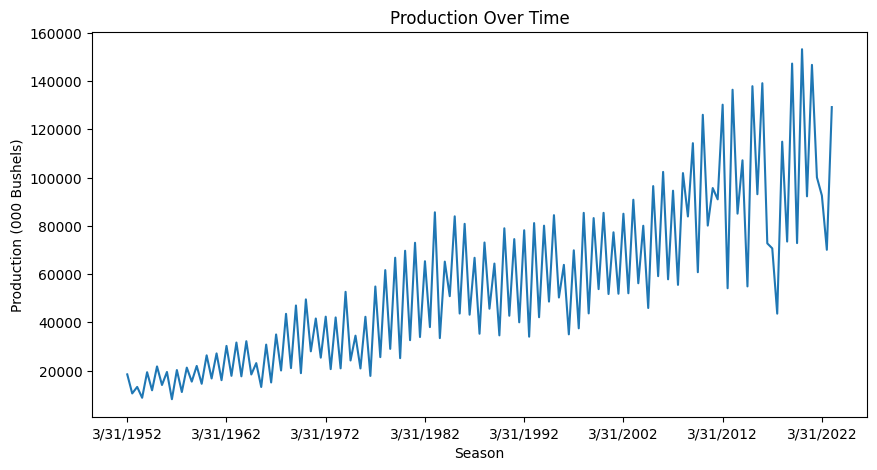

In [35]:

from statsmodels.tsa.stattools import adfuller

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np


# Plot the production data
df['Production (000 Bushels)'].plot(figsize=(10, 5), title='Production Over Time', ylabel='Production (000 Bushels)')
plt.show()







In [36]:
# Descriptive Statistics
print("Descriptive Statistics:")
print(df.describe())


Descriptive Statistics:
       Average Yield (Bushels/Acre)  Production (000 Bushels)
count                    143.000000                143.000000
mean                      60.663287              56041.384615
std                       18.973936              34449.899204
min                       26.440000               8100.000000
25%                       43.380000              26700.000000
50%                       64.830000              50271.000000
75%                       76.935000              80038.000000
max                       94.960000             153207.000000


# Check for Stationarity

In [37]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Perform the ADF test
result = adfuller(df['Production (000 Bushels)'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value > 0.05, apply differencing
if result[1] > 0.05:
    df["Log_Production"] = np.log(df["Production (000 Bushels)"])

ADF Statistic: 0.15164470529217952
p-value: 0.9694152935788198


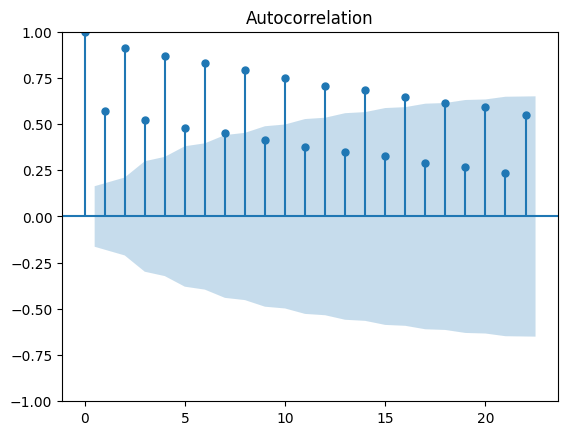

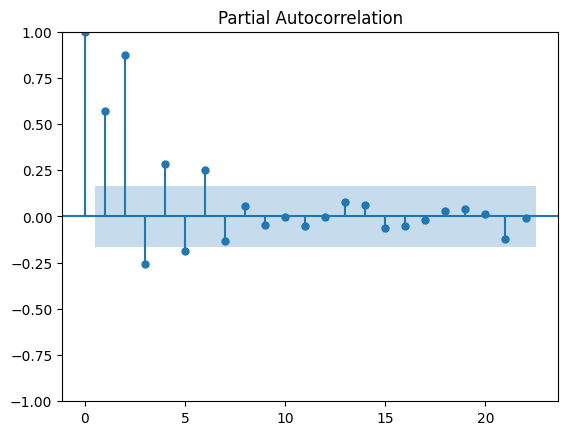

In [38]:
import matplotlib.pyplot as plt

plot_acf(df['Log_Production'].dropna(),alpha=0.05)
plot_pacf(df['Log_Production'].dropna(),alpha=0.05)
plt.show()




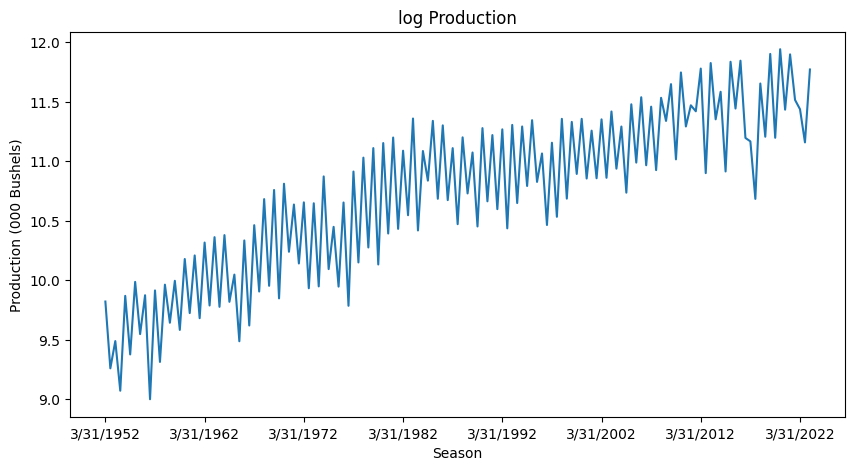

In [8]:
# Plot the production data
df['Log_Production'].plot(figsize=(10, 5), title='log Production', ylabel='Production (000 Bushels)')
plt.show()

According to this ACF plot still it shows a non stationary time series.

In [39]:

# Perform the ADF test
result = adfuller(df['Log_Production'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.1942183079448054
p-value: 0.20835056590290013


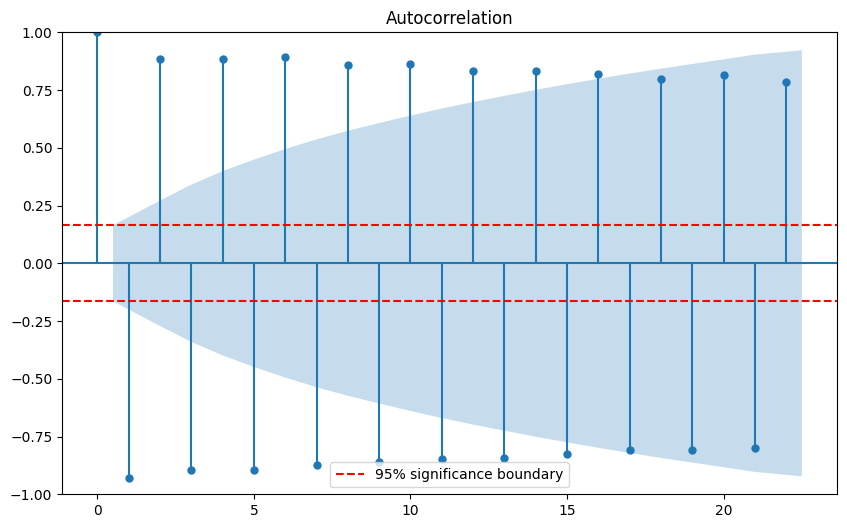

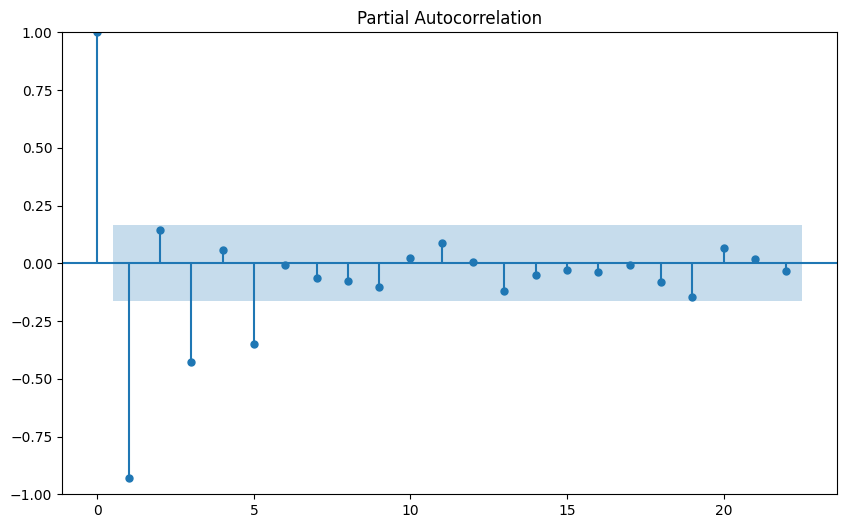

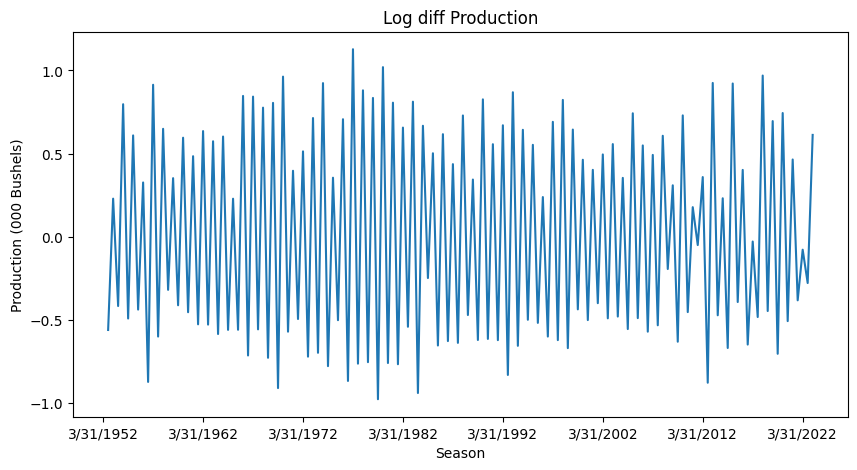

In [43]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# If p-value > 0.05, apply differencing for log production
if result[1] > 0.05:
    df["Log_Production_Diff"] = df["Log_Production"].diff().dropna()

n = len(df["Log_Production_Diff"])

# Compute the critical value for 95% significance level
critical_value = 1.96 / np.sqrt(n)

# Create a new figure and axis for the ACF plot
fig, ax = plt.subplots(figsize=(10, 6))

plot_acf(df['Log_Production_Diff'].dropna(), alpha=0.05, ax=ax)

# Add horizontal dashed lines at the significance levels
ax.axhline(y=critical_value, linestyle='--', color='red', label='95% significance boundary')
ax.axhline(y=-critical_value, linestyle='--', color='red')
ax.legend()

# Create a new figure for the PACF plot, if desired
fig2, ax2 = plt.subplots(figsize=(10, 6))
plot_pacf(df['Log_Production_Diff'].dropna(), alpha=0.05, ax=ax2)
plt.show()

# Plot the production data
df['Log_Production_Diff'].plot(figsize=(10, 5), title='Log diff Production', ylabel='Production (000 Bushels)')
plt.show()


In [11]:
# Perform the ADF test
df_diff = df["Log_Production_Diff"].dropna()
result = adfuller(df_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -6.328539155799233
p-value: 2.945119720708603e-08


p value is 2.94*10^(-8) is less than 0.05. Therefore, the series is now stationary after applying the logarithmic transformation and differencing.

* The ACF tapers off gradually. This is indicative of an autoregressive process rather than a moving average process.

* The PACF cuts off sharply after lag 1. This suggests that an AR(1) (Autoregressive of order 1) model might be appropriate.

p=1, d=1, q=0

**ARIMA(1, 1, 0) (AR term = 1, Differencing = 1, MA term = 0).**

In [12]:
from statsmodels.tsa.arima.model import ARIMA
# Define ARIMA model
model = ARIMA(df['Production (000 Bushels)'], order=(1, 1, 0))

# Fit the model
model_fit = model.fit()

# Print the summary
print(model_fit.summary())



                                  SARIMAX Results                                   
Dep. Variable:     Production (000 Bushels)   No. Observations:                  143
Model:                       ARIMA(1, 1, 0)   Log Likelihood               -1566.208
Date:                      Mon, 31 Mar 2025   AIC                           3136.416
Time:                              15:38:14   BIC                           3142.328
Sample:                                   0   HQIC                          3138.818
                                      - 143                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9160      0.028    -32.943      0.000      -0.970      -0.861
sigma2      2.237e+08    1.5e-11   1.49e+19      0.000    2.24e+08    2.24e+08
Ljun

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Check for Heteroskedasticity

SARIMAX results refers to the Breusch-Pagan test for heteroscedasticity.
* Null Hypothesis (H₀): Residuals have constant variance (homoscedasticity).
* Alternative Hypothesis (H₁): Residuals do not have constant variance (heteroscedasticity).

The p-value (0.00) is significantly below 0.05, so we reject the null hypothesis. This means heteroscedasticity is present, and the variance of residuals is not constant.

---



From the SARIMAX results:
Heteroskedasticity (H): 21.17, Prob(H): 0.00.
* A high H-statistic and a p-value of 0.00 indicate significant heteroskedasticity in the residuals. This confirms that the residuals' variance is not constant.

JB = 81.75, Prob(JB): 0.00.
* The non-normality in residuals (based on JB test) may also stem from changing variance.

In [13]:
from statsmodels.stats.diagnostic import het_arch

# Perform ARCH test on residuals
arch_test = het_arch(model_fit.resid)
print(f'ARCH Test Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')


ARCH Test Statistic: 61.22145119533344
p-value: 2.1270151043956916e-09


In [14]:
df.reset_index(inplace=True) #change date data type
print(df.head())


      Season Sown (000 Acres) Harvested (000 Acres)  \
0  3/31/1952              738                   700   
1  8/31/1952              424                   402   
2  3/31/1953              655                   586   
3  8/31/1953              394                   366   
4  3/31/1954              770                   743   

   Average Yield (Bushels/Acre)  Production (000 Bushels)  Log_Production  \
0                         30.85                     18400        9.820106   
1                         30.70                     10500        9.259131   
2                         26.44                     13200        9.487972   
3                         27.90                      8700        9.071078   
4                         30.07                     19300        9.867860   

   Log_Production_Diff  
0                  NaN  
1            -0.560975  
2             0.228842  
3            -0.416894  
4             0.796782  


Since the p-value < 0.05, there is evidence of heteroskedasticity, and ARCH/GARCH modeling is required.

#Bootstrap residuals to estimate confidence intervals

In [15]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.asfreq('6M')  # '6M' for semi-annual data
# Convert date column to datetime and set as index
df['date'] = pd.to_datetime(df['Season'])
df.set_index('date', inplace=True)

# Convert all numeric columns to float
df = df.apply(pd.to_numeric, errors='coerce')




<ipython-input-15-459375c26869>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('6M')  # '6M' for semi-annual data


In [16]:
# Resample with proper frequency
df = df.asfreq('6ME')  # Set semi-annual frequency (Month-End)
df = df.resample('6ME').mean()  # Aggregate using mean
df.head()

,Season,Sown (000 Acres),Harvested (000 Acres),Average Yield (Bushels/Acre),Production (000 Bushels),Log_Production,Log_Production_Diff
date,,,,,,,


In [45]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import statsmodels.api as sm

def bootstrap_forecast(data, n_bootstraps=1000, forecast_horizon=5):
    forecasts = []

    # Ensure the data is sorted and has a proper frequency
    data = data.sort_index()

    for _ in range(n_bootstraps):
        # Resample the data with replacement while preserving the time index
        bootstrapped_data = resample(data, replace=True)
        bootstrapped_data = pd.Series(bootstrapped_data.values, index=data.index)  # Reattach index

        # Fit an ARIMA model
        model = sm.tsa.ARIMA(bootstrapped_data, order=(1, 1, 0), trend='n')
        fitted_model = model.fit()

        # Forecast the next 'forecast_horizon' steps
        forecast = fitted_model.forecast(steps=forecast_horizon)
        forecasts.append(forecast.values)  # Extract forecasted values

    # Compute confidence intervals
    forecasts = np.array(forecasts)
    lower_bound = np.percentile(forecasts, 2.5, axis=0)
    upper_bound = np.percentile(forecasts, 97.5, axis=0)

    for i in range(forecast_horizon):
        print(f"Forecast {i+1}: 95% CI = ({lower_bound[i]:.4f}, {upper_bound[i]:.4f})")

    return lower_bound, upper_bound

# Example usage
np.random.seed(42)  # For reproducibility
data = pd.Series(np.random.randn(100).cumsum(), index=pd.date_range("2020-01-01", periods=100, freq="6M"))
bootstrap_forecast(data)


<ipython-input-45-43c06251108c>:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = pd.Series(np.random.randn(100).cumsum(), index=pd.date_range("2020-01-01", periods=100, freq="6M"))


Forecast 1: 95% CI = (-10.8104, 1.8500)
Forecast 2: 95% CI = (-10.7827, 2.3627)
Forecast 3: 95% CI = (-10.7534, 1.8940)
Forecast 4: 95% CI = (-10.7822, 2.1603)
Forecast 5: 95% CI = (-10.7584, 2.0389)


(array([-10.81044572, -10.78272955, -10.7534379 , -10.78223583,
        -10.75838921]),
 array([1.84999976, 2.36267302, 1.89397013, 2.16033135, 2.03887723]))

<ipython-input-57-e0b164d5fc11>:62: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = pd.Series(np.random.randn(50).cumsum(), index=pd.date_range("2010-01-01", periods=50, freq="6M"))  # Semi-Annual Data
<ipython-input-57-e0b164d5fc11>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(data.index[-1], periods=forecast_horizon+1, freq="6M")[1:]


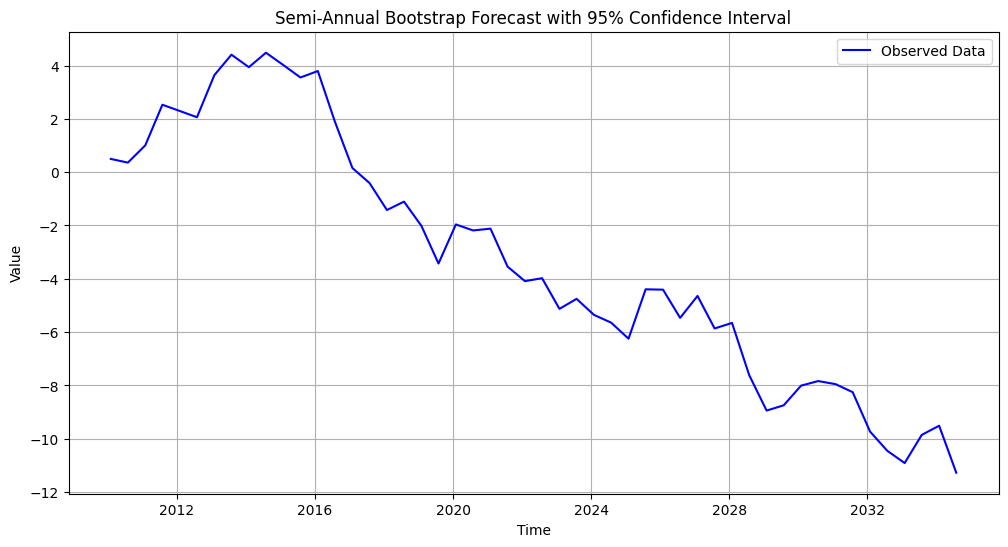

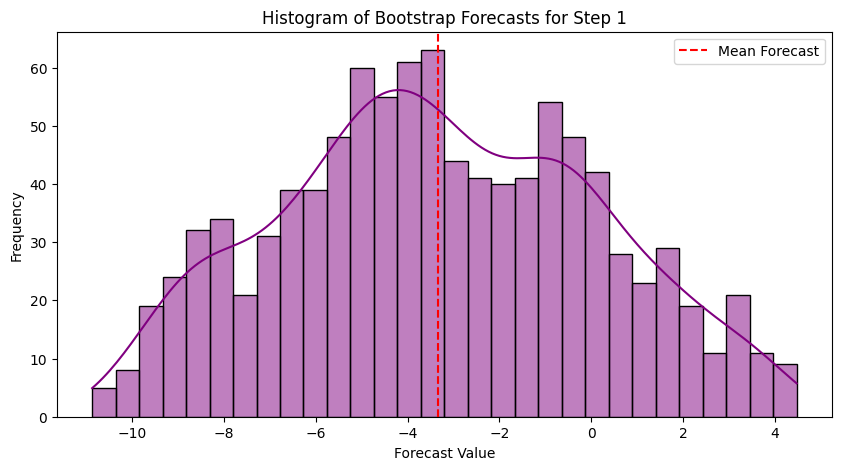

(array([-9.60767881, -9.76874768, -9.6533695 , -9.66652291, -9.6590207 ]),
 array([3.217189  , 3.59375327, 3.44293925, 3.54792266, 3.48462378]))

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import statsmodels.api as sm
def bootstrap_forecast(data, n_bootstraps=1000, forecast_horizon=5):
    forecasts = []

    # Ensure data is sorted and has a proper frequency
    data = data.sort_index()

    for _ in range(n_bootstraps):
        # Resample the data with replacement
        bootstrapped_data = resample(data, replace=True)
        bootstrapped_data = pd.Series(bootstrapped_data.values, index=data.index)  # Keep the same index

        # Fit an ARIMA model
        model = sm.tsa.ARIMA(bootstrapped_data, order=(1, 1, 0), trend='n')
        fitted_model = model.fit()

        # Forecast the next 'forecast_horizon' steps
        forecast = fitted_model.forecast(steps=forecast_horizon)
        forecasts.append(forecast.values)

    # Convert forecasts into a NumPy array
    forecasts = np.array(forecasts)

    # Compute confidence intervals
    lower_bound = np.percentile(forecasts, 2.5, axis=0)
    upper_bound = np.percentile(forecasts, 97.5, axis=0)

    mean_forecast = np.mean(forecasts, axis=0)

    # Generate future dates for semi-annual steps
    future_dates = pd.date_range(data.index[-1], periods=forecast_horizon+1, freq="6M")[1:]

    # 📊 **Plot 1: Time Series with Forecasts**
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data, label="Observed Data", color="blue")
    plt.title("Semi-Annual Bootstrap Forecast with 95% Confidence Interval")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

        # 📊 **Plot 2: Histogram of Forecasts (for first forecast step)**
    plt.figure(figsize=(10, 5))
    sns.histplot(forecasts[:, 0], bins=30, kde=True, color="purple")
    plt.axvline(mean_forecast[0], color="red", linestyle="dashed", label="Mean Forecast")
    plt.title(f"Histogram of Bootstrap Forecasts for Step 1")
    plt.xlabel("Forecast Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return lower_bound, upper_bound

# 🟢 **Generate Example Semi-Annual Data**
np.random.seed(42)
data = pd.Series(np.random.randn(50).cumsum(), index=pd.date_range("2010-01-01", periods=50, freq="6M"))  # Semi-Annual Data
bootstrap_forecast(data)


* The observed data has a downward trend, indicating possible declines in future values.
* The forecast suggests a stabilization, but the large confidence interval indicates uncertainty.
* Future values are expected to fluctuate within the gray-shaded area.

Timestamp('2034-07-31 00:00:00')

<ipython-input-60-e228df59ff6b>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = list(pd.date_range(start="1952-01-01", end="2023-03-31", freq="6M"))
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


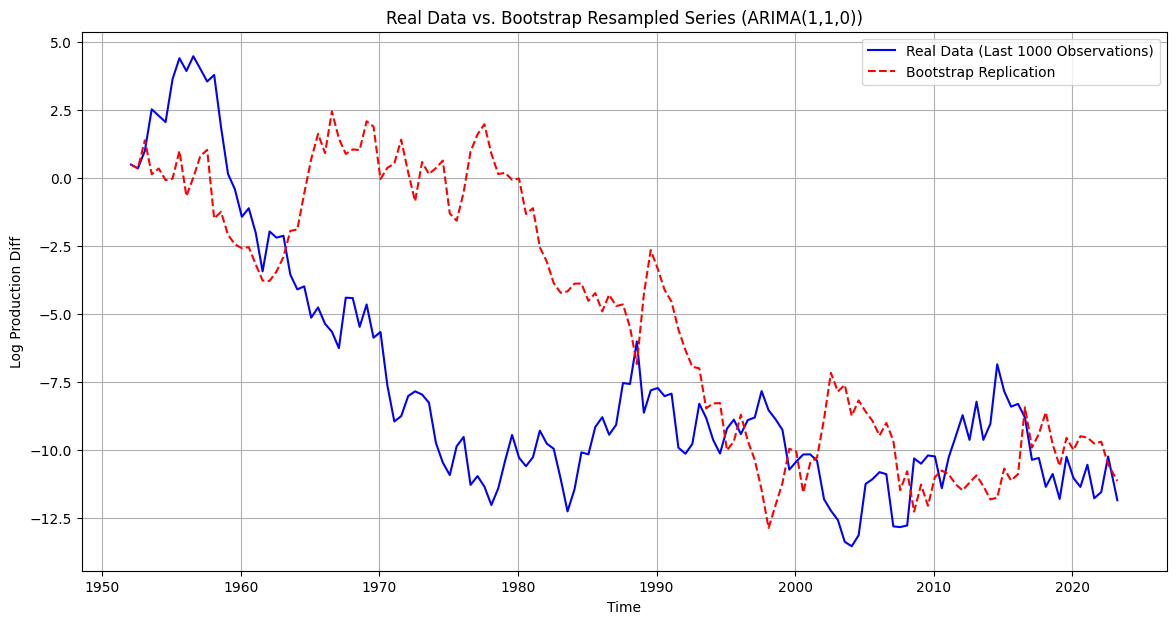

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- Simulate Semi-Annual Data (Replace with your actual df) ---
# Create a date range with semiannual frequency (adjusting the final two dates)
dates = list(pd.date_range(start="1952-01-01", end="2023-03-31", freq="6M"))
dates[-2] = pd.Timestamp("2022-07-31")
dates[-1] = pd.Timestamp("2023-03-31")
dates = pd.to_datetime(dates)

np.random.seed(42)
df = pd.DataFrame({
    'Log_Production_Diff': np.random.randn(len(dates)).cumsum()
}, index=dates)

# --- Select the Last 1000 Observations of the Real Data ---
# (If fewer than 1000 exist, this will use all available data)
real_data = df['Log_Production_Diff'].iloc[-1000:]

# --- Fit an ARIMA(1,1,0) Model to the Real Data ---
model = sm.tsa.ARIMA(real_data, order=(1, 1, 0), trend='n')
results = model.fit()

# Retrieve the AR coefficient (named "ar.L1")
phi = results.params["ar.L1"]

# Get the residuals from the fitted model (used as the empirical distribution of shocks)
residuals = results.resid

# --- Define a Function to Perform the Residual-Based Bootstrap Simulation ---
def bootstrap_arima_110_simulation(series, phi, residuals):
    """
    Generate one bootstrap replication of an ARIMA(1,1,0) series using residual resampling.

    Parameters:
      series     : pd.Series; the observed series to match (used for initial conditions and index)
      phi        : float; AR(1) coefficient from the fitted model.
      residuals: pd.Series; residuals from the fitted model.

    Returns:
      pd.Series containing the bootstrap replication, on the same time index as 'series'.
    """
    n = len(series)
    # Use the first two observations as starting values
    y0 = series.iloc[0]
    y1 = series.iloc[1]
    d_prev = y1 - y0
    boot_series = [y0, y1]

    # For each subsequent time point, simulate using the AR(1) in differences:
    for i in range(2, n):
        # Resample a shock (ε) from the residuals (with replacement)
        shock = np.random.choice(residuals, replace=True)
        # Compute the new difference: Δyₜ = φ * Δyₜ₋₁ + εₜ
        d_new = phi * d_prev + shock
        # Update the level: yₜ = yₜ₋₁ + Δyₜ
        y_new = boot_series[-1] + d_new
        boot_series.append(y_new)
        d_prev = d_new  # update for next iteration

    return pd.Series(boot_series, index=series.index)

# --- Generate a Bootstrap Replication ---
bootstrap_series = bootstrap_arima_110_simulation(real_data, phi, residuals)

# --- Plot the Real Data (Last 1000 Points) and the Bootstrap Series Together ---
plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_data, label='Real Data (Last 1000 Observations)', color='blue')
plt.plot(bootstrap_series.index, bootstrap_series, label='Bootstrap Replication', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Log Production Diff')
plt.title('Real Data vs. Bootstrap Resampled Series (ARIMA(1,1,0))')
plt.legend()
plt.grid(True)
plt.show()
